<font size="6">**Task 1: data mining**</font>

**1.1 Get pokemon data from pokeAPI**

In [ ]:
import requests
import json
import os

# 定义保存图片的目录
save_directory = "data/pokemon_images"
os.makedirs(save_directory, exist_ok=True)

# 获取所有宝可梦的基本信息
url = "https://pokeapi.co/api/v2/pokemon?limit=10000"
response = requests.get(url)
data = response.json()

# 创建一个字典来存储宝可梦的名称和属性
pokemon_info = {}

# 遍历每个宝可梦
for pokemon in data['results']:
    pokemon_name = pokemon['name']
    pokemon_url = pokemon['url']
    response = requests.get(pokemon_url)
    pokemon_data = response.json()

    # 获取宝可梦的属性
    types = pokemon_data['types']
    type_names = [type_info['type']['name'] for type_info in types]

    # 获取宝可梦的图片链接
    pic1_url = pokemon_data['sprites']['other']['official-artwork']['front_default']
    pic2_url = pokemon_data['sprites']['other']['home']['front_default']
    pic3_url = pokemon_data['sprites']['front_default']

    # 下载并保存图片
    for i, pic_url in enumerate([pic1_url, pic2_url, pic3_url], start=1):
        if pic_url:
            img_response = requests.get(pic_url)
            if img_response.status_code == 200:
                img_name = f"{pokemon_name}_pic{i}.png"
                img_path = os.path.join(save_directory, img_name)
                with open(img_path, 'wb') as file:
                    file.write(img_response.content)

    # 将宝可梦的名称和属性存储到字典中
    pokemon_info[pokemon_name] = {
        "types": type_names,
        "images": [os.path.join(save_directory, f"{pokemon_name}_pic{i}.png") for i in range(1, 4) if eval(f"pic{i}_url")]
    }

# 将字典转换为 JSON 格式并保存到文件中
with open('data/pokemon_info.json', 'w') as json_file:
    json.dump(pokemon_info, json_file, indent=4)

print(f"所有宝可梦的名称和属性已保存到 pokemon_info.json 文件中，图片保存在 {save_directory} 目录中。")

所有宝可梦的名称和属性已保存到 pokemon_info.json 文件中，图片保存在 data/pokemon_images 目录中。


**1.2 Palworlds**

In [ ]:
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
url = 'https://palworld.wiki.gg/wiki/Pals'
response = requests.get(url)
names = []
numbers = []
elements = []
response = requests.get(url)
if response.status_code == 200:
    html_content = response.text
    soup = BeautifulSoup(html_content, 'html.parser')
    tables = soup.find_all('table')
    for table in tables:
        tbody = table.find('tbody')
        if tbody:
            trs = tbody.find_all('tr')
            for tr in trs[1:]:
                name_a_tag = tr.find('span', class_='iconlink').find_all('a')[1]
                name = name_a_tag.get_text(strip=True)
                number = tr.find_all('td')[1].get_text(strip=True)
                ele = []
                for span_tag in tr.find_all('span'):
                    if span_tag.name == 'span' and "ele-" in ' '.join(span_tag.get("class", [])):
                        element_a_tag = span_tag.find('a')
                        element = element_a_tag.get_text(strip=True) if element_a_tag else "Unknown"
                        ele.append(element)
                element = ', '.join(ele) if ele else "Unknown"
                names.append(name)
                numbers.append(number)
                elements.append(element)
            df = pd.DataFrame({'No.': numbers,
                               'Name': names,
                               'Elements': elements})
            csv_file_path = 'pals_data.csv'
            df.to_csv(csv_file_path, index=False)

In [ ]:
def download_image(image_url, image_name, folder="images"):
    image_path = os.path.join(folder, image_name)
    response = requests.get(image_url)

    if response.status_code == 200:
        with open(image_path, 'wb') as f:
            f.write(response.content)
        print(f"download：{image_path}")
    else:
        print(f"error：{response.status_code}")
def extract_image_urls(soup):
    image_urls = []

    screenshot_div = soup.find('div', id='pi-tab-1')
    if screenshot_div:
        screenshot_img = screenshot_div.find('img')
        if screenshot_img:
            image_urls.append(screenshot_img['src'])

    icon_div = soup.find('div', id='pi-tab-2')
    if icon_div:
        icon_img = icon_div.find('img')
        if icon_img:
            image_urls.append(icon_img['src'])

    return image_urls

data=pd.read_csv('pals_data.csv')
# names = data['Name'].tolist()
index = data.index[data['Name'] == 'Petallia'].tolist()
names = data['Name'].iloc[index[0]:].tolist()
for name in names:
    name=name.replace(' ','_')
    url=f'https://palworld.wiki.gg/wiki/{name}'
    response = requests.get(url)
    html_content = response.text
    soup = BeautifulSoup(html_content, 'html.parser')

    image_urls = extract_image_urls(soup)
    for i, image_url in enumerate(image_urls):
        if 'icon' in image_url:
            image_name = f'{name}_icon.png'
        else:
            image_name = f'{name}.png'

        image_url=f'https://palworld.wiki.gg{image_url}'
        download_image(image_url, image_name)

**1.3 roco kingdom**

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup

import time
import pandas as pd
import os
import urllib.request
url = 'https://rocokingdom.huijiwiki.com/wiki/%E5%AE%A0%E7%89%A9%E5%9B%BE%E9%89%B4'

def open_driver(url):
    options = webdriver.ChromeOptions()
    options.add_experimental_option('excludeSwitches', ['enable-logging']) # for ignore warning and error
    driver = webdriver.Chrome(options=options)
    driver.get(url)
    return driver

year=2014
i=year-2008

driver = open_driver(url)
per_year_button = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.XPATH,f'/html/body/div[2]/div/div[1]/main/article/section[1]/div/div/div/div[2]/div/div/div[{i}]'))
)
per_year_button.click()

WebDriverWait(driver, 30).until(
    EC.invisibility_of_element_located((By.XPATH, "//div[@class='pet-name' and text()='苦行骆驼']")))


time.sleep(10)
WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.CLASS_NAME, "pet-card")))
# time.sleep(10)

page_source = driver.page_source
soup = BeautifulSoup(page_source, 'html.parser')
pet_cards = soup.find_all(class_="pet-card")

names = []
numbers = []
elements = []
for pet_card in pet_cards:
    number = pet_card.find('div', class_='pet-title huiji-tt').get('data-name')
    name = pet_card.find('div', class_='pet-name').text
    element = [img.get('title') for img in pet_card.find_all('img')]
    element = element[1:len(element)-1]
    element = [x for x in element if x is not None]
    element = '，'.join(element)
    names.append(name)
    numbers.append(number)
    elements.append(element)

df = pd.DataFrame({'No.': numbers,
                    'Name': names,
                    'Elements': elements })

    # encoding problem
    # csv_file_path = 'roco_kingdom_data_2010.csv'
    # df.to_csv(csv_file_path, index=False, encoding='utf-8')

txt_file_path = f'roco_kingdom_data_{year}.txt'
df.to_csv(txt_file_path, index=False, sep='\t', encoding='utf-8')



In [ ]:
import urllib.request
year=2014
i=year-2008

url = 'https://rocokingdom.huijiwiki.com/wiki/%E5%AE%A0%E7%89%A9%E5%9B%BE%E9%89%B4'

# Terminal: /Applications/Google\ Chrome.app/Contents/MacOS/Google\ Chrome --remote-debugging-port=9222
def create_driver():
    chrome_options = Options()
    chrome_options.add_experimental_option("debuggerAddress", "127.0.0.1:9222")
    driver = webdriver.Chrome(options=chrome_options)
    return driver

driver = create_driver()
driver.get(url)
time.sleep(2)
opener = urllib.request.build_opener()
opener.addheaders = [('User-Agent', 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36')]
urllib.request.install_opener(opener)

per_year_button = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.XPATH,f'/html/body/div[2]/div/div[1]/main/article/section[1]/div/div/div/div[2]/div/div/div[{i}]'))
)
per_year_button.click()

WebDriverWait(driver, 30).until(
    EC.invisibility_of_element_located((By.XPATH, "//div[@class='pet-name' and text()='苦行骆驼']")))

time.sleep(10)
WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.CLASS_NAME, "pet-card")))

page_source = driver.page_source
soup = BeautifulSoup(page_source, 'html.parser')
pet_cards = soup.find_all(class_="pet-card")

for pet_card in pet_cards[len(pet_cards)-34:]:
    number = pet_card.find('div', class_='pet-title huiji-tt').get('data-name')
    name = pet_card.find('div', class_='pet-name').text
    image_url = pet_card.find('img', alt=True)
    high_res_url = image_url['srcset'].split(' ')[0]
    urllib.request.urlretrieve(high_res_url, f'images_{year}/No.{number}_{name}.png')
    print(f"download: No.{number}_{name}.png")


**1.4 SEER**

1.4.1 Crawling data from 4399

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import ElementNotInteractableException, NoSuchElementException
from bs4 import BeautifulSoup

import requests
import pandas as pd
import urllib.request
import time
# Terminal: /Applications/Google\ Chrome.app/Contents/MacOS/Google\ Chrome --remote-debugging-port=9222
def create_driver():
    chrome_options = Options()
    chrome_options.add_experimental_option("debuggerAddress", "127.0.0.1:9222")
    driver = webdriver.Chrome(options=chrome_options)
    return driver

url = 'https://news.4399.com/seer/jinglingdaquan/'
driver = create_driver()
driver.get(url)

mode_button=driver.find_element(By.XPATH,'//*[@id="tab4"]/li[2]/a')
mode_button.click()

while True:
    try:
        more_button=driver.find_element(By.XPATH,'/html/body/div[6]/div[5]/a')
        more_button.click()
        time.sleep(1)
    except ElementNotInteractableException:
        break

pet_cards=driver.find_elements(By.CLASS_NAME,'jl_list2')
pet_cards = pet_cards[0].text
pet_cards = pet_cards.split('\n')
pet_cards = [x for x in pet_cards if not ('形态等级'in x or '种族值'in x or '专属技能'in x or '查询捕捉'in x or '详细信息' in x)]
#print(pet_cards)
names = []
numbers = []
elements = []

for index, info in enumerate(pet_cards):
    if index % 3 == 0 and info:
        names.append(info)
    elif index % 3 == 1 and '精灵ID' in info:
        number = info.split('：')[-1]
        numbers.append(number)
    elif index % 3 == 2 and '精灵属性' in info:
        element = info.split('：')[-1]
        elements.append(element)

link_urls = []
i=1
while True:
    try:
        card_link=driver.find_element(By.XPATH,f'/html/body/div[6]/ul[2]/li[{i}]/a')
        link_url = card_link.get_attribute('href')
        link_urls.append(link_url)
        i+=1
    except NoSuchElementException:
        break
df = pd.DataFrame({'No.': [int(number) for number in numbers],
                   'Name': names,
                   'Elements': elements,
                   'URL':link_urls})
df_sorted = df.sort_values(by='No.', ascending=True)
print(df_sorted)
csv_file_path = 'seer_data_4399.txt'
df_sorted.to_csv(csv_file_path, index=False,sep='\t', encoding='utf-8')

In [ ]:
url = 'https://news.4399.com/seer/jinglingdaquan/'

# Terminal: /Applications/Google\ Chrome.app/Contents/MacOS/Google\ Chrome --remote-debugging-port=9222
def create_driver():
    chrome_options = Options()
    chrome_options.add_experimental_option("debuggerAddress", "127.0.0.1:9222")
    driver = webdriver.Chrome(options=chrome_options)
    return driver

driver = create_driver()
driver.get(url)
def process_link(driver, index):
    li_xpath = f'//*[@id="state"]/div[1]/ul/li[{index}]'
    time.sleep(1)
    li_element = driver.find_element(By.XPATH, li_xpath)
    span_element = None
    try:
        span_element = li_element.find_element(By.XPATH, './/span')
    except NoSuchElementException:
        return None, None, None, None

    img_xpath = f'//*[@id="state"]/div[1]/ul/li[{index}]/a/img'
    time.sleep(1)
    img = driver.find_element(By.XPATH, img_xpath)
    pic = img.get_attribute('src')
    img.click()
    number = driver.find_element(By.XPATH, f'//*[@id="state"]/div[2]/dl[{index}]/dd/span[1]').text.replace('精灵序号：', '')
    name = driver.find_element(By.XPATH, f'//*[@id="state"]/div[2]/dl[{index}]/dt').text
    element = driver.find_element(By.XPATH, f'//*[@id="state"]/div[3]/dl[{index}]/dt/i').text
    return name, number, element, pic



In [ ]:
names = []
numbers = []
elements = []
pics = []

data=pd.read_csv('seer_data_4399.txt', sep='\t')
link_urls = data['URL']
link_urls = link_urls[665:]
for link_url in link_urls:
    driver.get(link_url)

    for index in range(1,4):
        name, number, element, pic = process_link(driver, index)
        if name and number and element:
            names.append(name)
            numbers.append(number)
            elements.append(element)
            pics.append(pic)
            print(f'{number}, {name}, {element}, {pic}')

    time.sleep(1)

df = pd.DataFrame({'No.': [int(number) for number in numbers],
                   'Name': names,
                   'Elements': elements,
                   'image_url': pics})

df_sorted = df.sort_values(by='No.', ascending=True)
print(df_sorted)
csv_file_path = 'seer_data_4399_1.txt'
df_sorted.to_csv(csv_file_path, index=False,sep='\t', encoding='utf-8')

df=pd.read_csv('seer_data_4399_1.txt',sep='\t')
df.head()

1.4.2 Crawling data from wiki

In [ ]:
url = 'https://seerelvesinpokemonstyle.fandom.com/zh/wiki/%E7%B2%BE%E7%81%B5%E5%88%97%E8%A1%A8%EF%BC%88%E6%8C%89%E5%85%A8%E5%9F%9F%E5%9B%BE%E9%89%B4%E7%BC%96%E5%8F%B7%EF%BC%89?variant=zh-cn'
driver = create_driver()
driver.get(url)
time.sleep(3)
table=driver.find_element(By.XPATH,'/html/body/div[6]/div[4]/div[4]/main/div[3]/div/div/table[1]')

names = []
numbers = []
elements = []
for i in range(1,192):
    number=driver.find_element(By.XPATH,f'/html/body/div[6]/div[4]/div[4]/main/div[3]/div/div/table[1]/tbody/tr[{i}]/td[1]').text

    try:
        name=driver.find_element(By.XPATH,f'/html/body/div[6]/div[4]/div[4]/main/div[3]/div/div/table[1]/tbody/tr[{i}]/td[3]/a').text
    except NoSuchElementException:
        try:
            name=driver.find_element(By.XPATH,f'//*[@id="mw-content-text"]/div/table[1]/tbody/tr[{i}]/td[3]/span').text
        except NoSuchElementException:
            name = None

    ele = driver.find_element(By.XPATH, f'/html/body/div[6]/div[4]/div[4]/main/div[3]/div/div/table[1]/tbody/tr[{i}]/td[4]').text
    ele2 = None
    try:
        ele2 = driver.find_element(By.XPATH, f'/html/body/div[6]/div[4]/div[4]/main/div[3]/div/div/table[1]/tbody/tr[{i}]/td[5]').text
    except NoSuchElementException:
        pass

    if ele2:
        ele = [ele, ele2]
        ele = '，'.join(ele)
    else:
        ele = ele

    # fig = driver.find_element(By.XPATH,f'/html/body/div[6]/div[4]/div[4]/main/div[3]/div/div/table[1]/tbody/tr[{i}]/td[2]/a')
    # fig_url=fig.get_attribute('href')
    # urllib.request.urlretrieve(fig_url, f'images/No.{number}_{name}.png')
    # print(f'downlaod: No.{number}_{name}.png')

    names.append(name)
    numbers.append(number)
    elements.append(ele)

df = pd.DataFrame({'No.': [int(number) for number in numbers],
                   'Name': names,
                   'Elements': elements})

csv_file_path = 'seer_data_wiki.txt'
df.to_csv(csv_file_path, index=False,sep='\t', encoding='utf-8')





1.4.3 Translate Chinese into English

In [ ]:
import os
from pypinyin import lazy_pinyin
import pandas as pd
directory_path = '/Users/fonglengsut/Desktop/introduction of ds/group project/other games/seer/images'
rename_files(directory_path)
def add_english_names_to_txt(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            file_path = os.path.join(directory, filename)
            df=pd.read_csv(file_path,sep='\t')
            if 'Name' in df.columns:
                df['Eng_Name'] = df['Name'].apply(lambda x: ''.join(lazy_pinyin(x)))
                df.to_csv(file_path, index=False, sep=',')

In [ ]:
directory_path = '/Users/fonglengsut/Desktop/introduction of ds/group project/other games/seer'
add_english_names_to_txt(directory_path)

<font size="6">**Task 2: Training of pokemon type**</font>

**2.1 Preprocessing**

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

# 定义自定义数据集类
class PokemonDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        self.data_dict = data_dict
        self.transform = transform
        self.image_files = []
        self.labels = []

        # 遍历数据字典，获取所有图像文件路径和对应的标签（属性）
        for pokemon_name, info in data_dict.items():
            for img_path in info['images']:
                self.image_files.append(img_path)
                self.labels.append(info['types'])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")

        # 获取宝可梦的标签（属性）
        labels = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        # 将字符串标签转换为整数标签
        label_map = {'grass': 0, 'poison': 1, 'fire': 2, 'water': 3, 'electric': 4, 'ice': 5, 'fighting': 6,
                     'ground': 7, 'flying': 8, 'psychic': 9, 'bug': 10, 'rock': 11, 'ghost': 12, 'dark': 13,
                     'dragon': 14, 'steel': 15, 'fairy': 16, 'normal': 17}
        labels = [label_map[label] for label in labels]

        # 将标签转换为多标签二进制格式
        multi_label = torch.zeros(len(label_map), dtype=torch.float32)
        for label in labels:
            multi_label[label] = 1.0

        return image, multi_label

# 读取数据字典
with open('data/pokemon_info.json', 'r') as f:
    data_dict = json.load(f)

# 定义训练数据的转换
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# 创建数据集
pokemon_dataset = PokemonDataset(data_dict=data_dict, transform=data_transforms)

# 将数据集分割为训练集、验证集和测试集（80%、10%、10%）
train_size = int(0.8 * len(pokemon_dataset))
val_size = int(0.1 * len(pokemon_dataset))
test_size = len(pokemon_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(pokemon_dataset, [train_size, val_size, test_size])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


**2.2 Model and training**

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import cv2
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# 定义自定义数据集类
class PokemonDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        self.data_dict = data_dict
        self.transform = transform
        self.image_files = []
        self.labels = []

        # 遍历数据字典，获取所有图像文件路径和对应的标签（属性）
        for pokemon_name, info in data_dict.items():
            for img_path in info['images']:
                self.image_files.append(img_path)
                self.labels.append(info['types'])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]

        # 使用OpenCV加载图像
        image = cv2.imread(img_path)
        if image is None:
            print(f"UnidentifiedImageError: cannot identify image file '{img_path}'")
            return self.__getitem__((idx + 1) % len(self.image_files))

        # 将图像从BGR转换为RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 获取宝可梦的标签（属性）
        labels = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        # 将字符串标签转换为整数标签
        label_map = {'grass': 0, 'poison': 1, 'fire': 2, 'water': 3, 'electric': 4, 'ice': 5, 'fighting': 6,
                     'ground': 7, 'flying': 8, 'psychic': 9, 'bug': 10, 'rock': 11, 'ghost': 12, 'dark': 13,
                     'dragon': 14, 'steel': 15, 'fairy': 16, 'normal': 17}
        labels = [label_map[label] for label in labels]

        # 将标签转换为多标签二进制格式
        multi_label = torch.zeros(len(label_map), dtype=torch.float32)
        for label in labels:
            multi_label[label] = 1.0

        return image, multi_label

# 定义函数来提取图像特征
def extract_features(model, dataloader):
    model.eval()
    features = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
    return np.concatenate(features)


# 读取数据字典
with open('data/pokemon_info.json', 'r') as f:
    data_dict = json.load(f)

# 定义训练数据的转换
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# 创建数据集
pokemon_dataset = PokemonDataset(data_dict=data_dict, transform=data_transforms)

# 将数据集分割为训练集、验证集和测试集（80%、10%、10%）
train_size = int(0.8 * len(pokemon_dataset))
val_size = int(0.1 * len(pokemon_dataset))
test_size = len(pokemon_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(pokemon_dataset, [train_size, val_size, test_size])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# 检查是否有可用的GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 加载预训练的ResNet18模型
model = models.resnet18(pretrained=True)

# 修改最后一层以匹配属性的数量（假设有18种可能的属性）
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 18)

# 将模型移动到GPU
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 训练循环
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs_labels in train_loader:
        if inputs_labels is None:
            continue

        inputs, labels = inputs_labels

        # 将输入和标签移动到GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    # 验证循环
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs_labels in val_loader:
            if inputs_labels is None:
                continue

            inputs, labels = inputs_labels

            # 将输入和标签移动到GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Validation Loss: {val_loss/len(val_loader)}")

print("Training complete.")

# 测试循环（可选）
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs_labels in test_loader:
        if inputs_labels is None:
            continue

        inputs, labels = inputs_labels

        # 将输入和标签移动到GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        test_loss += loss.item()

print(f"Test Loss: {test_loss/len(test_loader)}")



Using device: cuda:0
Epoch 1/20, Loss: 0.3015347325624271
Validation Loss: 0.28118698222121014
Epoch 2/20, Loss: 0.2769729947487925
Validation Loss: 0.26360021900270403
Epoch 3/20, Loss: 0.2636679448959432
Validation Loss: 0.2527120541205111
Epoch 4/20, Loss: 0.25308770371765055
Validation Loss: 0.2441973531829942
Epoch 5/20, Loss: 0.24287912857578825
Validation Loss: 0.2363066161723481
Epoch 6/20, Loss: 0.23445101987589825
Validation Loss: 0.2303259541693422
Epoch 7/20, Loss: 0.22668955533963103
Validation Loss: 0.22565625984336912
Epoch 8/20, Loss: 0.21940744281239768
Validation Loss: 0.2215224751799377
Epoch 9/20, Loss: 0.20787746508465837
Validation Loss: 0.21708014538300405
Epoch 10/20, Loss: 0.19980790511429927
Validation Loss: 0.2146109573005401
Epoch 11/20, Loss: 0.19193015428057297
Validation Loss: 0.21295362611099616
Epoch 12/20, Loss: 0.1812104575741322
Validation Loss: 0.21135934019826122
Epoch 13/20, Loss: 0.17058763386672024
Validation Loss: 0.20369247996161893
Epoch 14/2

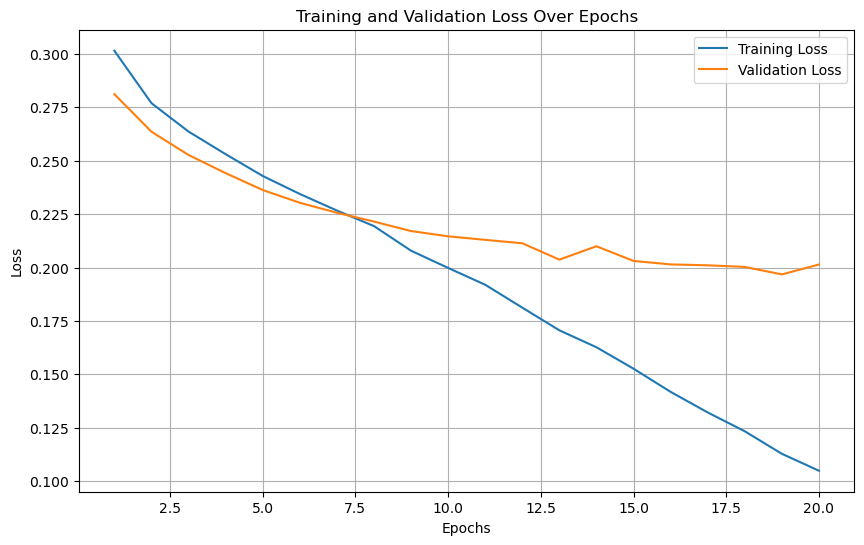

In [ ]:
import matplotlib.pyplot as plt

# Given training and validation loss data
epochs = list(range(1, 21))
training_loss = [0.3015347325624271, 0.2769729947487925, 0.2636679448959432, 0.25308770371765055, 0.24287912857578825,
                 0.23445101987589825, 0.22668955533963103, 0.21940744281239768, 0.20787746508465837, 0.19980790511429927,
                 0.19193015428057297, 0.1812104575741322, 0.17058763386672024, 0.16265154782431732, 0.15261471620881495,
                 0.1417701702873787, 0.1321228461513788, 0.12329844008513528, 0.11275986282376892, 0.10482501660816256]
validation_loss = [0.28118698222121014, 0.26360021900270403, 0.2527120541205111, 0.2441973531829942,
                   0.2363066161723481, 0.2303259541693422, 0.22565625984336912, 0.2215224751799377,
                   0.21708014538300405, 0.2146109573005401, 0.21295362611099616, 0.21135934019826122,
                   0.20369247996161893, 0.20995871907042474, 0.2030828278703788, 0.2014562721104966,
                   0.20103522678165092, 0.20027692888661758, 0.19677516879494658, 0.20139268113626646]

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

<font size="6">**Task 3: Analysis of types from other games**</font>

In [ ]:
import torch
import torch.nn.functional as F

# 定义属性标签
label_map = ['grass', 'poison', 'fire', 'water', 'electric', 'ice', 'fighting',
             'ground', 'flying', 'psychic', 'bug', 'rock', 'ghost', 'dark',
             'dragon', 'steel', 'fairy', 'normal']

def get_top3_attributes(outputs):
    """
    从模型输出中获取前三个可能的属性及其概率，保证概率和为1
    Args:
        outputs (torch.Tensor): 模型的输出，形状为 [batch_size, num_classes]

    Returns:
        List[List[Tuple[str, float]]]: 每个样本的前三个属性及其概率
    """
    # 应用 Sigmoid 激活函数，将 logits 转化为概率
    probabilities = torch.sigmoid(outputs)  # [batch_size, num_classes]

    # 获取前三个属性及其概率
    top3_indices = torch.topk(probabilities, 3, dim=1).indices  # [batch_size, 3]
    top3_probs = torch.topk(probabilities, 3, dim=1).values  # [batch_size, 3]

    # 对前三个概率进行正规化，使其和为1
    normalized_probs = F.normalize(top3_probs, p=1, dim=1)  # L1 正规化

    # 映射属性名称和概率
    results = []
    for sample_indices, sample_probs in zip(top3_indices, normalized_probs):
        sample_result = [(label_map[idx], prob.item()) for idx, prob in zip(sample_indices, sample_probs)]
        results.append(sample_result)

    return results

# 示例输出 (batch_size=4, num_classes=18)
outputs = torch.tensor([[1.2, -0.5, 0.7, 1.0, 0.2, -0.1, 0.9, -1.0, 0.3, 1.5, 0.8, -0.3, 0.5, -0.2, 1.1, 0.4, -0.4, 0.6],
                        [0.2, 0.7, -1.0, 1.2, 0.5, 0.9, -0.6, 0.8, -0.7, 0.4, 1.0, 0.6, -0.2, 0.3, -0.5, 1.1, 0.9, 0.8]])

# 获取每个样本的前三个属性及其概率
results = get_top3_attributes(outputs)
for i, res in enumerate(results):
    print(f"Sample {i+1}: {res}")

In [ ]:
model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)  # 模型输出 logits

        # 获取每个样本的前三个属性
        top3_attributes = get_top3_attributes(outputs)
        for idx, attrs in enumerate(top3_attributes):
            print(f"Test Sample {idx+1}: {attrs}")

In [ ]:
query_image_path = 'images/Anubis.png'
image = process_image(query_image_path)
if image is None:
    print("Error: Image processing failed.")
else:
    # 将图像传入模型
    image = image.to(device)  # 将图片移到GPU
    with torch.no_grad():
        outputs = model(image)  # 获取模型输出的 logits

    # 获取前三个属性并打印
    top3_attributes = get_top3_attributes(outputs)
print(f"Top 3 attributes for {query_image_path}:")

# 因为是单张图片，所以 top3_attributes 是一个包含一个元素的列表
for idx, (attr, prob) in enumerate(top3_attributes[0]):  # top3_attributes[0] 获取第一个（也是唯一的）元素
    print(f"{idx + 1}. {attr}: {prob:.4f}")

3.2 visualization

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
pip install torchvision

In [2]:
import pandas as pd

# Load the Palworlds data
palworlds_data_path = '/content/drive/MyDrive/Pokemon_type-main/data/palworld_data.csv'
data = pd.read_csv(palworlds_data_path)

# Filter records with the Dark attribute
dark_pals = data[data['Elements'].str.contains('Dark', case=False, na=False)]
print(f"Found {len(dark_pals)} Dark attribute entries.")

# Extract image names
dark_pal_names = dark_pals['Name'].tolist()

Found 35 Dark attribute entries.


Found 35 Dark attribute entries.


<ipython-input-10-972a7af358b0>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Image /content/drive/MyDrive/Pokemon_type-main/data/palworld_images/Incineram Noct.png does not exist, skipping.
Image /content/drive/MyDrive/Pokemon_type-main/data/palworld_images/Pyrin Noct.png does not exist, skipping.
Image /content/drive/MyDrive/Pokemon_type-main/data/palworld_images/Vanwyrm Cryst.png does not exist, skipping.
Image /content/drive/MyDrive/Pokemon_type-main/data/palworld_images/Bushi Noct.png does not exist, skipping.
Image /content/drive/MyDrive/Pokemon_type-main/data/palworld_images/Katress Ignis.png does not exist, skipping.
Image /content/drive/MyDrive/Pokemon_type-main/data/palworld_images/Wixen Noct.png does not exist, skipping.
Image /content/drive/MyDrive/Pokemon_type-main/data/palworld_images/Blazehowl Noct.png does not exist, skipping.
Image /content/drive/MyDrive/Pokemon_type-main/data/palworld_images/Helzephyr Lux.png does not exist, skipping.
Image /content/drive/MyDrive/Pokemon_type-main/data/palworld_images/Lyleen Noct.png does not exist, skipping.
I

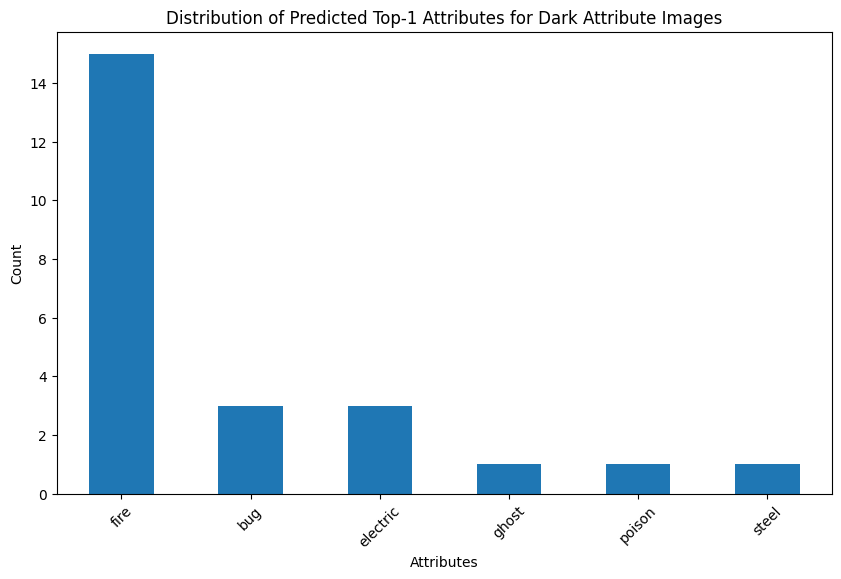

In [10]:
import os
import pandas as pd
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the Palworlds data
palworlds_data_path = '/content/drive/MyDrive/Pokemon_type-main/data/palworld_data.csv'
data = pd.read_csv(palworlds_data_path)

# Filter records with the Dark attribute
dark_pals = data[data['Elements'].str.contains('Dark', case=False, na=False)]
print(f"Found {len(dark_pals)} Dark attribute entries.")

# Extract image names
dark_pal_names = dark_pals['Name'].tolist()

# Load the pre-trained model
model = models.resnet18(weights=None)

# Modify the last layer to match the number of classes
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 18)  # Assuming there are 18 classes

# Load model weights
model_path = '/content/best_pokemon_model.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
])

# Define class names
class_names = ['grass', 'poison', 'fire', 'water', 'electric', 'ice', 'fighting',
               'ground', 'flying', 'psychic', 'bug', 'rock', 'ghost', 'dark',
               'dragon', 'steel', 'fairy', 'normal']

results = []  # To store predictions for each image

# Iterate through Dark attribute images
for name in dark_pal_names:
    image_path = f"/content/drive/MyDrive/Pokemon_type-main/data/palworld_images/{name}.png"  # Image path
    if os.path.exists(image_path):
        # Load the image
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

        # Get model predictions
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            top3_prob, top3_idx = torch.topk(probabilities, k=3)  # Top-3 predictions
            predicted_classes = [class_names[idx] for idx in top3_idx[0]]  # Convert to class names

        # Save results
        results.append({
            'Name': name,
            'Top-1': predicted_classes[0],
            'Top-2': predicted_classes[1],
            'Top-3': predicted_classes[2],
            'Top-1_Prob': top3_prob[0][0].item(),
            'Top-2_Prob': top3_prob[0][1].item(),
            'Top-3_Prob': top3_prob[0][2].item()
        })
    else:
        print(f"Image {image_path} does not exist, skipping.")

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df.head())

# Save results to a file
results_df.to_csv('dark_attribute_predictions.csv', index=False)

# Visualize the distribution of the most predicted attribute (Top-1) for the Dark attribute images
top1_attributes = results_df['Top-1'].value_counts()

plt.figure(figsize=(10, 6))
top1_attributes.plot(kind='bar')
plt.xlabel('Attributes')
plt.ylabel('Count')
plt.title('Distribution of Predicted Top-1 Attributes for Dark Attribute Images')
plt.xticks(rotation=45)
plt.show()

Distribution of Predicted Top-1 Attributes :
Visualize the distribution of the most predicted attribute (Top-1) for the Dark attribute images.

<ipython-input-11-372ec043ad33>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top1_counts.index, y=top1_counts.values, palette='viridis')


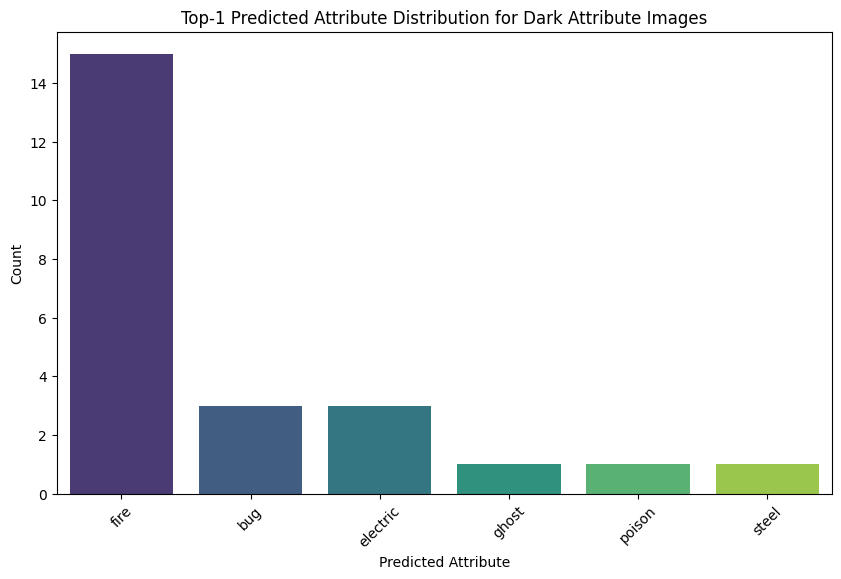

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count Top-1 predictions
top1_counts = results_df['Top-1'].value_counts()

# Plot a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=top1_counts.index, y=top1_counts.values, palette='viridis')
plt.title('Top-1 Predicted Attribute Distribution for Dark Attribute Images')
plt.xlabel('Predicted Attribute')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Top-3 Attribute Combinations:
Visualize the combination of Top-3 predicted attributes to see common patterns.

<ipython-input-13-68bf1e0f1af5>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top3_df['Combination'], x=top3_df['Count'], palette='coolwarm')


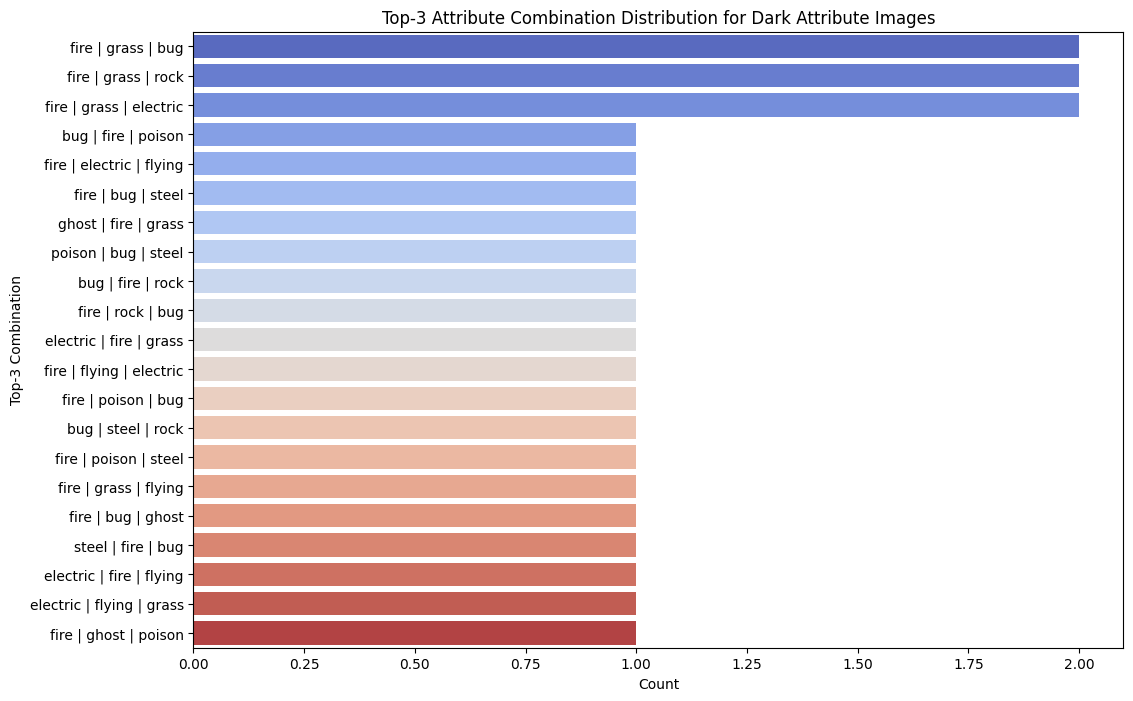

In [13]:
from collections import Counter

# Count Top-3 attribute combinations
top3_combinations = results_df[['Top-1', 'Top-2', 'Top-3']].apply(tuple, axis=1)
top3_counts = Counter(top3_combinations)

# Convert to a DataFrame
top3_df = pd.DataFrame(top3_counts.items(), columns=['Combination', 'Count']).sort_values(by='Count', ascending=False)

# Convert the MultiIndex to string for plotting
top3_df['Combination'] = top3_df['Combination'].apply(lambda x: ' | '.join(x))

# Plot a bar chart
plt.figure(figsize=(12, 8))
sns.barplot(y=top3_df['Combination'], x=top3_df['Count'], palette='coolwarm')
plt.title('Top-3 Attribute Combination Distribution for Dark Attribute Images')
plt.xlabel('Count')
plt.ylabel('Top-3 Combination')
plt.show()

Prediction Probability Distribution:
Visualize the probability distribution of Top-1, Top-2, and Top-3 predictions to analyze confidence levels.

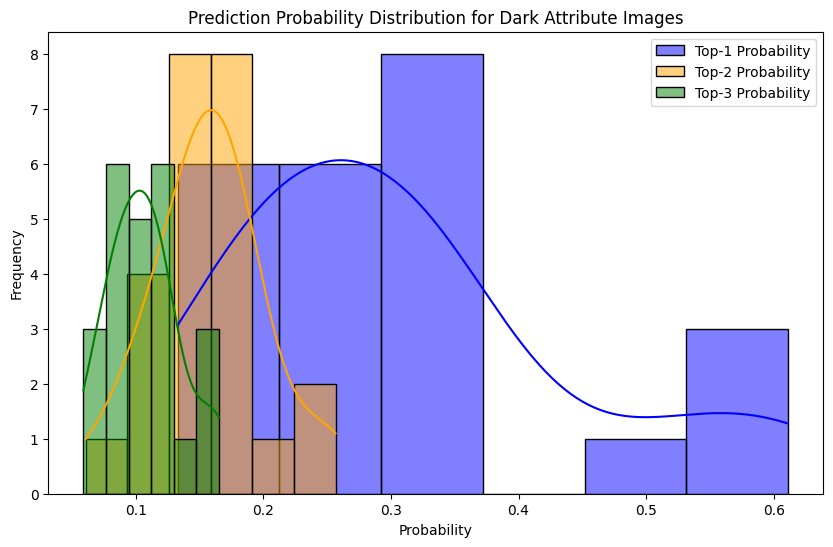

In [14]:
# Plot prediction probability distributions
plt.figure(figsize=(10, 6))
sns.histplot(results_df['Top-1_Prob'], kde=True, label='Top-1 Probability', color='blue')
sns.histplot(results_df['Top-2_Prob'], kde=True, label='Top-2 Probability', color='orange')
sns.histplot(results_df['Top-3_Prob'], kde=True, label='Top-3 Probability', color='green')
plt.title('Prediction Probability Distribution for Dark Attribute Images')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<font size="6">**Task 4: Most similar pokemon**</font>

**4.1 Different functions of calculation of similarity**

4.1.1 cosine_similarity

In [ ]:
# 示例：查找与查询图像最相似的三个宝可梦图像
# 定义函数来找到最相似的宝可梦图像
def find_similar_images(query_image_path, model, feature_extractor, dataset, dataloader, top_k=3):
    # 加载查询图像并进行预处理
    query_image = cv2.imread(query_image_path)
    if query_image is None:
        raise ValueError(f"Cannot identify image file '{query_image_path}'")

    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
    query_image = data_transforms(query_image).unsqueeze(0).to(device)

    # 提取查询图像的特征
    with torch.no_grad():
        query_features = feature_extractor(query_image).cpu().numpy()

    # 提取数据集中所有图像的特征
    dataset_features = extract_features(feature_extractor, dataloader)

    # 计算余弦相似度
    similarities = cosine_similarity(query_features, dataset_features)

    # 找到最相似的图像索引
    top_k_indices = np.argsort(similarities[0])[::-1][:top_k]

    # 返回最相似的图像路径和相似度分数
    similar_images = [(dataset.image_files[idx], similarities[0][idx]) for idx in top_k_indices]

    return similar_images

query_image_path = 'data/palworld_images/Anubis.png'
similar_images = find_similar_images(query_image_path, model, model, pokemon_dataset, train_loader, top_k=3)
print("Most similar images:")
for img_path, score in similar_images:
    print(f"Image: {img_path}, Similarity Score: {score}")

Most similar images:
Image: data/pokemon_images\omanyte_pic1.png, Similarity Score: 0.9607487916946411
Image: data/pokemon_images\roserade_pic2.png, Similarity Score: 0.9476977586746216
Image: data/pokemon_images\fraxure_pic1.png, Similarity Score: 0.9373520612716675


4.1.2 Euclidean

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

def find_similar_images_euclidean(query_image_path, model, feature_extractor, dataset, dataloader, top_k=3):
    query_image = cv2.imread(query_image_path)
    if query_image is None:
        raise ValueError(f"Cannot identify image file '{query_image_path}'")

    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
    query_image = data_transforms(query_image).unsqueeze(0).to(device)

    with torch.no_grad():
        query_features = feature_extractor(query_image).cpu().numpy()

    dataset_features = extract_features(feature_extractor, dataloader)

    distances = euclidean_distances(query_features, dataset_features)

    top_k_indices = np.argsort(distances[0])[:top_k]

    similar_images = [(dataset.image_files[idx], distances[0][idx]) for idx in top_k_indices]

    return similar_images

query_image_path = 'data/palworld_images/Anubis.png'
similar_images = find_similar_images_euclidean(query_image_path, model, model, pokemon_dataset, train_loader, top_k=3)
print("Most similar images:")
for img_path, score in similar_images:
    print(f"Image: {img_path}, Distance: {score}")

Most similar images:
Image: data/pokemon_images\nidoqueen_pic2.png, Distance: 9.441254615783691
Image: data/pokemon_images\toxapex_pic2.png, Distance: 9.872849464416504
Image: data/pokemon_images\kirlia_pic3.png, Distance: 10.014799118041992


4.1.3 VGG

In [ ]:
from torchvision.models import vgg16

# 加载预训练的VGG16模型
vgg_model = vgg16(pretrained=True)
vgg_model.classifier = nn.Sequential(*list(vgg_model.classifier.children())[:-1])  # 移除最后一层
vgg_model = vgg_model.to(device)

def extract_vgg_features(model, dataloader):
    model.eval()
    features = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
    return np.concatenate(features)

query_image_path = 'data/palworld_images/Anubis.png'
similar_images = find_similar_images(query_image_path, vgg_model, vgg_model, pokemon_dataset, train_loader, top_k=3)
print("Most similar images:")
for img_path, score in similar_images:
    print(f"Image: {img_path}, Similarity Score: {score}")

C:\Users\业\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\业\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Most similar images:
Image: data/pokemon_images\inkay_pic3.png, Similarity Score: 0.46852004528045654
Image: data/pokemon_images\simipour_pic1.png, Similarity Score: 0.4677070379257202
Image: data/pokemon_images\koraidon_pic2.png, Similarity Score: 0.45726901292800903


4.1.4 Hashes

In [ ]:
import cv2
import imagehash
import numpy as np

def find_similar_images_hash(query_image_path, dataset, top_k=3):
    # 使用 OpenCV 读取图像
    query_image = cv2.imread(query_image_path)
    # OpenCV 读取的图像是 BGR 格式，需要转换为 RGB 格式
    query_image_rgb = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
    # 将图像转换为 Pillow 图像对象以使用 imagehash 库
    query_image_pil = Image.fromarray(query_image_rgb)
    query_hash = imagehash.phash(query_image_pil)

    image_hashes = []
    for img_path in dataset.image_files:
        # 使用 OpenCV 读取图像
        img = cv2.imread(img_path)
        # 转换为 RGB 格式
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # 转换为 Pillow 图像对象
        img_pil = Image.fromarray(img_rgb)
        # 计算图像哈希
        img_hash = imagehash.phash(img_pil)
        image_hashes.append((img_path, img_hash))

    similarities = [(img_path, 1 - (query_hash - img_hash) / len(query_hash.hash)**2) for img_path, img_hash in image_hashes]
    similarities.sort(key=lambda x: x[1], reverse=True)

    return similarities[:top_k]

query_image_path = 'data/palworld_images/Anubis.png'
# 假设 pokemon_dataset 是一个具有 image_files 属性的对象，该属性包含图像文件路径的列表
# 注意：你需要确保 pokemon_dataset 已经被正确定义并包含有效的图像文件路径
similar_images = find_similar_images_hash(query_image_path, pokemon_dataset, top_k=3)
print("Most similar images:")
for img_path, score in similar_images:
    print(f"Image: {img_path}, Similarity Score: {score}")

Most similar images:
Image: data/pokemon_images\pichu_pic3.png, Similarity Score: 0.75
Image: data/pokemon_images\chinchou_pic3.png, Similarity Score: 0.71875
Image: data/pokemon_images\porygon2_pic2.png, Similarity Score: 0.71875


4.1.5 Combined

In [ ]:
import numpy as np
import cv2
import torch
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import imagehash

def find_similar_images_combined(query_image_path, model, feature_extractor, dataset, dataloader, top_k=3):
    # 加载查询图像并进行预处理
    query_image = cv2.imread(query_image_path)
    if query_image is None:
        raise ValueError(f"Cannot identify image file '{query_image_path}'")
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
    query_image_tensor = data_transforms(query_image).unsqueeze(0).to(device)

    # 提取查询图像的特征
    with torch.no_grad():
        query_features = feature_extractor(query_image_tensor).cpu().numpy()

    # 提取数据集中所有图像的特征
    dataset_features = extract_features(feature_extractor, dataloader)

    # 计算余弦相似度
    cosine_similarities = cosine_similarity(query_features, dataset_features)

    # 计算哈希相似度
    query_image_pil = Image.fromarray(query_image)
    query_hash = imagehash.phash(query_image_pil)
    image_hashes = []
    for img_path in dataset.image_files:
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
        img_hash = imagehash.phash(img_pil)
        image_hashes.append((img_path, img_hash))

    # 计算哈希相似度的归一化分数（这里使用汉明距离的平方的倒数进行归一化）
    # 注意：由于phash产生的是64位的哈希值，因此最大可能的汉明距离是64
    max_hamming_distance = 64
    hash_similarities = []
    for img_path, img_hash in image_hashes:
        hamming_distance = query_hash - img_hash  # imagehash库支持直接相减得到汉明距离
        normalized_hash_similarity = 1 - (hamming_distance / max_hamming_distance)  # 归一化到[0, 1]
        hash_similarities.append((img_path, normalized_hash_similarity))

    # 创建一个字典来存储所有图像的路径和它们的加权相似度分数
    final_scores = {}
    for i, (img_path_cosine, cosine_score) in enumerate(zip(dataset.image_files, cosine_similarities[0])):
        # 由于hash_similarities也是按照dataset.image_files的顺序，因此可以直接用i索引
        img_path_hash, hash_score = hash_similarities[i]
        # 确保两者对应的是同一张图像（理论上应该是，但为了安全起见还是检查一下）
        assert img_path_cosine == img_path_hash, "Image paths mismatch between cosine and hash similarities"
        # 计算加权相似度分数
        final_score = 0.8 * cosine_score + 0.2 * hash_score
        final_scores[img_path_cosine] = final_score

    # 根据最终相似度分数排序，返回前三名
    sorted_final_scores = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_final_scores[:top_k]

query_image_path = 'data/palworld_images/Anubis.png'
# 假设 pokemon_dataset 是一个具有 image_files 属性的对象，该属性包含图像文件路径的列表
# 注意：你需要确保 pokemon_dataset 已经被正确定义并包含有效的图像文件路径
similar_images = find_similar_images_combined(query_image_path, model, model, pokemon_dataset, train_loader, top_k=3)
print("Most similar images:")
for img_path, score in similar_images:
    print(f"Image: {img_path}, Similarity Score: {score}")

Most similar images:
Image: data/pokemon_images\whirlipede_pic3.png, Similarity Score: 0.8699132442474367
Image: data/pokemon_images\rellor_pic3.png, Similarity Score: 0.8518013000488283
Image: data/pokemon_images\caterpie_pic3.png, Similarity Score: 0.8471257209777833


**4.2  Try to use unet model**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, n_classes, kernel_size=3, padding=1),
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # 全局平均池化

    def forward(self, x):
        enc = self.encoder(x)
        mid = self.middle(enc)
        dec = self.decoder(mid)
        out = self.global_avg_pool(dec)  # 形状变为 [batch_size, n_classes, 1, 1]
        return out.view(out.size(0), -1)  # 形状变为 [batch_size, n_classes]


# 初始化 UNet 模型
n_channels = 3  # 输入图像通道数（RGB 图像）
n_classes = 18  # 输出类别数（多标签分类）
model_u = UNet(n_channels, n_classes)

# 检查是否有可用的 GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model_u = model_u.to(device)

# 定义损失函数和优化器
criterion = nn.BCEWithLogitsLoss()  # 多标签分类任务的损失函数
optimizer = optim.Adam(model_u.parameters(), lr=0.001)  # 使用 Adam 优化器

Using device: cuda:0


In [ ]:
from PIL import Image, ImageFile, UnidentifiedImageError
ImageFile.LOAD_TRUNCATED_IMAGES = True

num_epochs = 40
for epoch in range(num_epochs):
    model_u.train()
    running_loss = 0.0
    for inputs_labels in train_loader:
        if inputs_labels is None:
            continue

        inputs, labels = inputs_labels

        # 将输入和标签移动到 GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model_u(inputs)

        # 将输出调整为与标签形状一致
        outputs = outputs.view(outputs.size(0), -1)
        labels = labels.view(labels.size(0), -1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    # 验证循环
    model_u.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs_labels in val_loader:
            if inputs_labels is None:
                continue

            inputs, labels = inputs_labels

            # 将输入和标签移动到 GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_u(inputs)

            # 将输出调整为与标签形状一致
            outputs = outputs.view(outputs.size(0), -1)
            labels = labels.view(labels.size(0), -1)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Validation Loss: {val_loss/len(val_loader)}")

print("Training complete.")


Epoch 1/40, Loss: 0.29572675599103765
Validation Loss: 0.2938861498205932
Epoch 2/40, Loss: 0.29342376415670846
Validation Loss: 0.29187320940887806
Epoch 3/40, Loss: 0.29265110920439114
Validation Loss: 0.29155574892599556
Epoch 4/40, Loss: 0.29261692968520475
Validation Loss: 0.2922781739652771
Epoch 5/40, Loss: 0.29270499404230266
Validation Loss: 0.29135680367651673
Epoch 6/40, Loss: 0.2923475724350603
Validation Loss: 0.29023011382093133
Epoch 7/40, Loss: 0.29211469066034945
Validation Loss: 0.2907717083532786
Epoch 8/40, Loss: 0.29219488403880534
Validation Loss: 0.2894417121238315
Epoch 9/40, Loss: 0.2914232803711311
Validation Loss: 0.28792982202829775
Epoch 10/40, Loss: 0.2907567130006039
Validation Loss: 0.288155108075781
Epoch 11/40, Loss: 0.29009782461150324
Validation Loss: 0.28611178988033964
Epoch 12/40, Loss: 0.2889221167201514
Validation Loss: 0.28576364544863553
Epoch 13/40, Loss: 0.2884591786586559
Validation Loss: 0.28445007982327764
Epoch 14/40, Loss: 0.28732194460

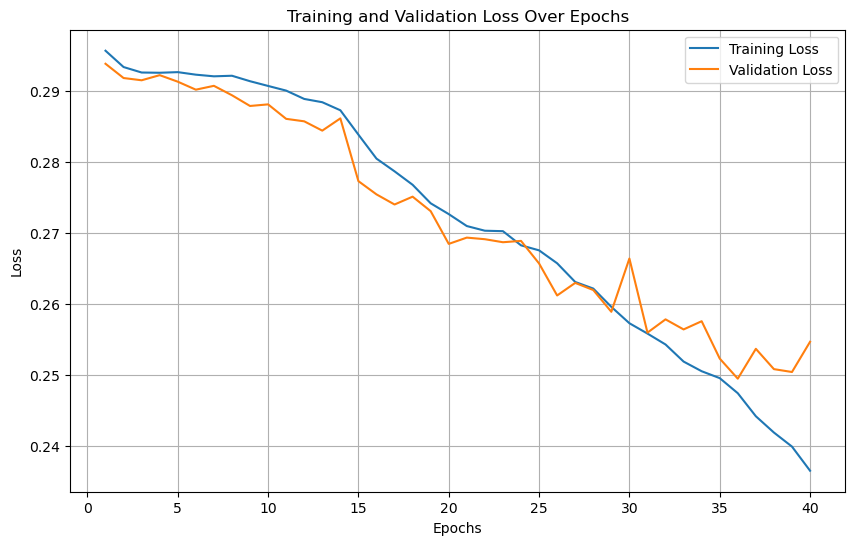

In [ ]:
# Given training and validation loss data
epochs = list(range(1, 41))
training_loss = [0.29572675599103765, 0.29342376415670846, 0.29265110920439114, 0.29261692968520475, 0.29270499404230266,
                 0.2923475724350603, 0.29211469066034945, 0.29219488403880534, 0.2914232803711311, 0.2907567130006039,
                 0.29009782461150324, 0.2889221167201514, 0.2884591786586559, 0.28732194460040544, 0.283882427786916,
                 0.2804991721605081, 0.2787053816869778, 0.27680726515351184, 0.27419393656321756, 0.2726688857909311,
                 0.2709844179953318, 0.27032382710030967, 0.2702601843470119, 0.26826268652637386, 0.26755428152071997,
                 0.26572950149601604, 0.26309181560660894, 0.2621617164617221, 0.2595774527697057, 0.2572686614594157,
                 0.25580839440226555, 0.25426877205081555, 0.25185738091834775, 0.25049485629086665, 0.24952182056951708,
                 0.24739120005982218, 0.24413987735546933, 0.241841937149899, 0.23985760171603354, 0.23645372899162337]
validation_loss = [0.2938861498205932, 0.29187320940887806, 0.29155574892599556, 0.2922781739652771,
                   0.29135680367651673, 0.29023011382093133, 0.2907717083532786, 0.2894417121238315,
                   0.28792982202829775, 0.288155108075781, 0.28611178988033964, 0.28576364544863553,
                   0.28445007982327764, 0.2861774159768193, 0.27732104877221214, 0.27545302461103066,
                   0.27402479639372873, 0.27512961195916247, 0.27308470978564825, 0.26846485131794645,
                   0.2693520764407423, 0.2691262410473578, 0.26870004417970006, 0.26888986392733977,
                   0.26570360669770193, 0.2611859419296697, 0.26295947367997513,
                   0.26195521913852887, 0.25888233363013907,
                   0.26639750123638467,
                   0.25594190285377894,
                   0.2578146913924168,
                   0.25639392312654513,
                   0.2575528758395578,
                   0.2522827737110177,
                   0.24944299152216962,
                   0.25365609621878754,
                   0.2507902188706644,
                   0.25038478039589124,
                   0.2546477270187791]

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
query_image_path = 'data/palworld_images/Anubis.png'
# 假设 pokemon_dataset 是一个具有 image_files 属性的对象，该属性包含图像文件路径的列表
# 注意：你需要确保 pokemon_dataset 已经被正确定义并包含有效的图像文件路径
similar_images = find_similar_images_combined(query_image_path, model_u, model_u, pokemon_dataset, train_loader, top_k=3)
print("Most similar images:")
for img_path, score in similar_images:
    print(f"Image: {img_path}, Similarity Score: {score}")

Most similar images:
Image: data/pokemon_images\tsareena_pic1.png, Similarity Score: 0.7474530220031739
Image: data/pokemon_images\meditite_pic1.png, Similarity Score: 0.7121516704559326
Image: data/pokemon_images\croconaw_pic3.png, Similarity Score: 0.7039288520812989
